## Credit Risk Modelling - Probability of Default

This notebook uses behavioral and application data to create and compare probability of default models uisng Logistic Regression and XG Boost.

1. Data Preperation
2. Initial Analysis
3. One Hot Encoding
4. Logistic Regression
5. XG Boost
6. Initial Comparison Logistic Regression with XGBoost
7. Feature Selection
8. Cross Validation
9. Class Imbalance
10. Model Evaluation
11. Credit Strategy

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import xgboost as xgb

### 1. Data Preperation


In [2]:
# load and print first 5 rows
df = pd.read_csv('cr_loan2.xls')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# Create the cross table for loan status, home ownership, and the max employment length
pd.crosstab(df['loan_status'],df['person_home_ownership'],
                  values=df['person_emp_length'], aggfunc='max')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,123.0,24.0,31.0,41.0
1,34.0,11.0,17.0,123.0


In [4]:
# Removing outliers where employment length is greater than 60
indices = df[df['person_emp_length'] > 60].index
df = df.drop(indices)

In [5]:
# Replacing missing data.
# We could alternatively use machine learning to predict a persons emplyment length and interest rate.
# For simplicity we will use median.
pd.isnull(df).sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [6]:
df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)

In [7]:
# We can't use these rows for training or testing the model.
indices = df[df['loan_int_rate'].isnull()].index
df = df.drop(indices)

### 2. Initial Analysis

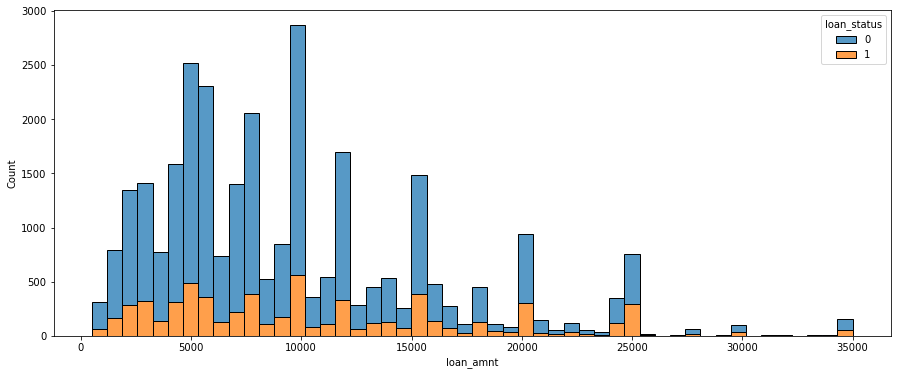

In [8]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(df, x="loan_amnt", hue="loan_status", multiple="stack", bins=50, ax=ax)

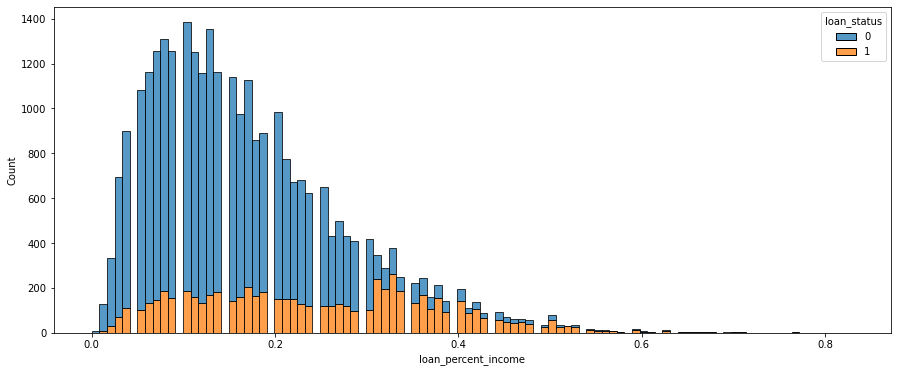

In [9]:
f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(df, x="loan_percent_income", hue="loan_status", multiple="stack", bins=100, ax=ax)

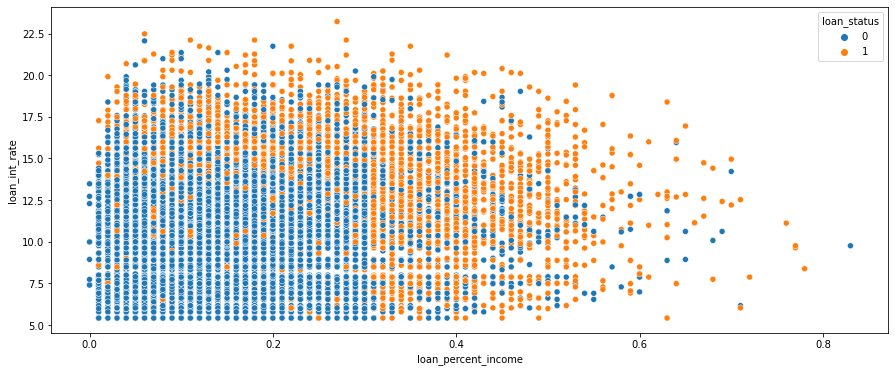

In [10]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(
    data=df,
    x="loan_percent_income", y="loan_int_rate",
    hue="loan_status",
     ax=ax,
)

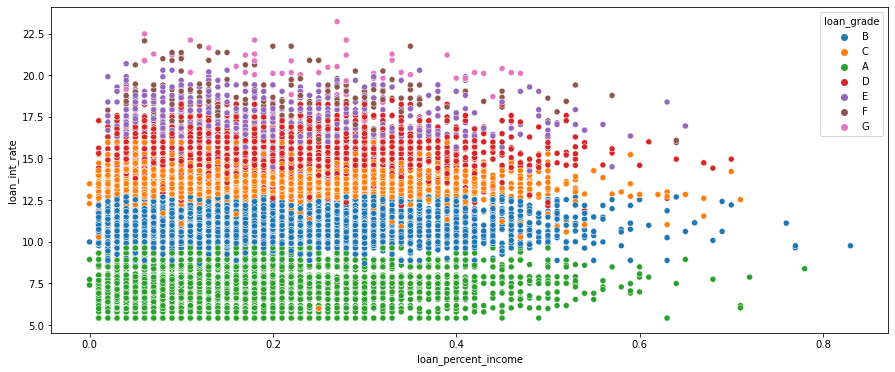

In [11]:
f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(
    data=df,
    x="loan_percent_income", y="loan_int_rate",
    hue="loan_grade",
     ax=ax,
)

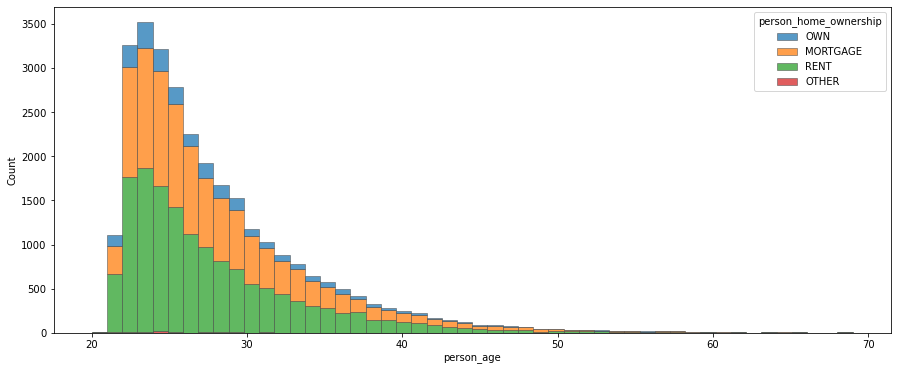

In [12]:
rage_df = df[df['person_age'] < 70]

f, ax = plt.subplots(figsize=(15, 6))
sns.histplot(rage_df, x="person_age", hue="person_home_ownership", multiple="stack", bins=50, ax=ax,     edgecolor=".3",
    linewidth=.5)

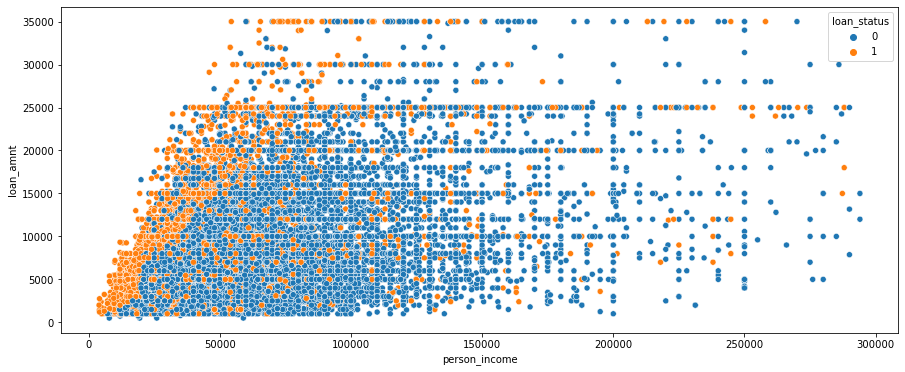

In [13]:
rincome_df = df[df['person_income'] < 300000]

f, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(
    data=rincome_df,
    x="person_income", y="loan_amnt",
    hue="loan_status",
     ax=ax,
)

In [14]:
pd.crosstab(df['loan_grade'], df['loan_status'])

loan_status,0,1
loan_grade,,
A,8796,977
B,7867,1528
C,4619,1209
D,1343,1970
E,310,571
F,64,150
G,1,58


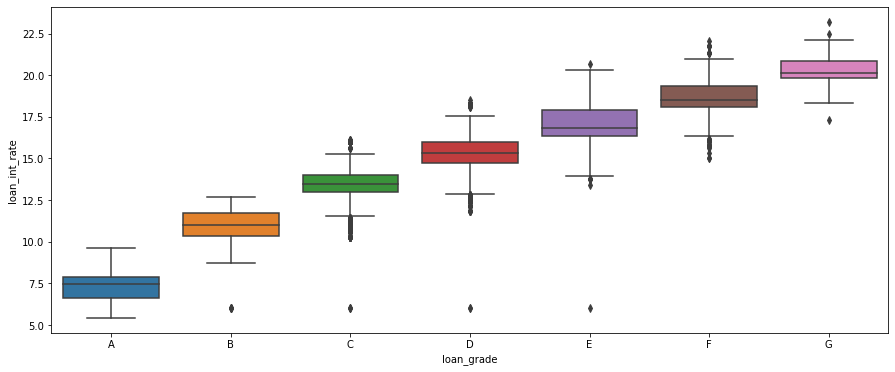

In [15]:
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x="loan_grade", y="loan_int_rate", data=df,ax=ax, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

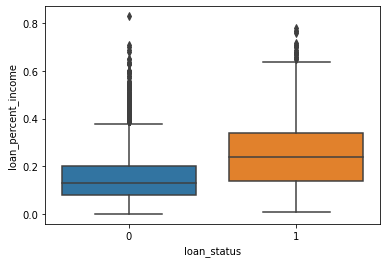

In [16]:
sns.boxplot(x="loan_status", y="loan_percent_income", data=df)

### 3. One Hot Encoding

In [17]:
# Create two data sets for numeric and non-numeric data
df_num = df.select_dtypes(exclude=['object'])
df_str = df.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
df_str_onehot = pd.get_dummies(df_str)

In [18]:
df_str_onehot.head()

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0


In [19]:
# Union the one-hot encoded columns to the numeric ones
df = pd.concat([df_num, df_str_onehot], axis=1)

# Print the columns in the new data set
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


### 4. Logistic Regression

In [20]:
# Create the X and y data sets
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [21]:
# Create and train a logistic regression
lr_model = LogisticRegression().fit(X_train, np.ravel(y_train))

In [22]:
# Create predictions of probability for loan status using test data
preds = lr_model.predict_proba(X_test)

# Create dataframes of predictions
lr_preds_df = pd.DataFrame(preds[:,1], columns = ['lr_prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
lr_portfolio = pd.concat([true_df.reset_index(drop = True), lr_preds_df, X_test['loan_amnt'].reset_index(drop = True)], axis = 1)
lr_portfolio['loss_given_default'] = 0.2
lr_portfolio.head()

,loan_status,lr_prob_default,loan_amnt,loss_given_default
0,0,0.130012,9000,0.2
1,0,0.059754,4000,0.2
2,0,0.129564,6300,0.2
3,0,0.456964,12400,0.2
4,0,0.376612,7500,0.2


### 5. XGBoost

In [23]:
# Create and train a XG Boost model
xgb_model = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
preds = xgb_model.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
xgb_preds_df = pd.DataFrame(preds[:,1], columns = ['xgb_prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
xgb_portfolio = pd.concat([true_df.reset_index(drop = True), xgb_preds_df, X_test['loan_amnt'].reset_index(drop = True)], axis = 1)
xgb_portfolio['loss_given_default'] = 0.2
xgb_portfolio.head()

,loan_status,xgb_prob_default,loan_amnt,loss_given_default
0,0,0.011106,9000,0.2
1,0,0.167985,4000,0.2
2,0,0.002628,6300,0.2
3,0,0.063230,12400,0.2
4,0,0.189694,7500,0.2


### 6. Initial Comparison Logistic Regression with XGBoost

In [24]:
# Create expected loss columns for each model using the formula
xgb_portfolio['xgb_expected_loss'] = xgb_portfolio['xgb_prob_default'] * xgb_portfolio['loss_given_default'] * xgb_portfolio['loan_amnt']
lr_portfolio['lr_expected_loss'] = lr_portfolio['lr_prob_default'] * lr_portfolio['loss_given_default'] * lr_portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(lr_portfolio['lr_expected_loss']))
print(accuracy_score(y_test, lr_model.predict(X_test)))

# Print the sum of the expected loss for gbt
print('XGB expected loss: ', np.sum(xgb_portfolio['xgb_expected_loss']))
print(accuracy_score(y_test, xgb_model.predict(X_test)))

LR expected loss:  5500678.485167352
0.8000169692855931
XGB expected loss:  5408946.915700949
0.9305107754963516


In [25]:
# Create expected loss columns for each model using the formula
xgb_portfolio['xgb_expected_loss'] = xgb_portfolio['loan_status'] * xgb_portfolio['loss_given_default'] * xgb_portfolio['loan_amnt']
lr_portfolio['lr_expected_loss'] = lr_portfolio['loan_status'] * lr_portfolio['loss_given_default'] * lr_portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR loss: ', np.sum(lr_portfolio['lr_expected_loss']))
print(accuracy_score(y_test, lr_model.predict(X_test)))

# Print the sum of the expected loss for gbt
print('XGB loss: ', np.sum(xgb_portfolio['xgb_expected_loss']))
print(accuracy_score(y_test, xgb_model.predict(X_test)))

LR loss:  5628345.0
0.8000169692855931
XGB loss:  5628345.0
0.9305107754963516


Precision – Accuracy of positive predictions. Precision = TP/(TP + FP)

Recall: Fraction of positives that were correctly identified. Recall = TP/(TP+FN)

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [26]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, lr_model.predict(X_test), target_names=target_names))
print(classification_report(y_test, xgb_model.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.80      0.98      0.88      9177
     Default       0.73      0.16      0.26      2609

    accuracy                           0.80     11786
   macro avg       0.76      0.57      0.57     11786
weighted avg       0.79      0.80      0.75     11786

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9177
     Default       0.94      0.73      0.82      2609

    accuracy                           0.93     11786
   macro avg       0.94      0.86      0.89     11786
weighted avg       0.93      0.93      0.93     11786



In [27]:
# Print the confusion matrix for both old and new models
print("Logistic Regression")
print(confusion_matrix(y_test,lr_model.predict(X_test)))
print("XG Boost")
print(confusion_matrix(y_test,xgb_model.predict(X_test)))

Logistic Regression
[[9024  153]
 [2204  405]]
XG Boost
[[9061  116]
 [ 703 1906]]


In [28]:
# Print and compare the AUC scores of the old and new models
print("Logistic Regression")
print(roc_auc_score(y_test, lr_model.predict(X_test)))
print("XG Boost")
print(roc_auc_score(y_test, xgb_model.predict(X_test)))

Logistic Regression
0.5692798872712971
XG Boost
0.8589539031640963


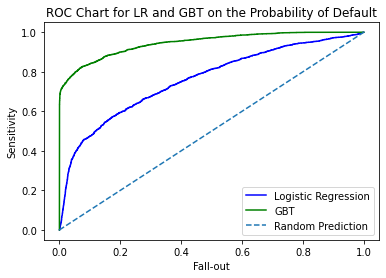

In [29]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [30]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.95


### 8. Cross validation

In [31]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

#params
params = {'objective':'binary:logistic' ,'seed':123,'eval_metric':'auc'}

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.903058       0.001980       0.898697      0.008435
1        0.909570       0.001214       0.903772      0.007847
2        0.913940       0.001938       0.908188      0.007294
3        0.918344       0.001861       0.911168      0.006633
4        0.922192       0.001223       0.915421      0.007330


In [32]:
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10, shuffle = True)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.903207       0.001835       0.898498      0.007795
1        0.909165       0.001227       0.904436      0.009030
2        0.913430       0.001430       0.908275      0.009130
3        0.917865       0.000877       0.911602      0.009454
4        0.921801       0.000827       0.915208      0.009788
0.95


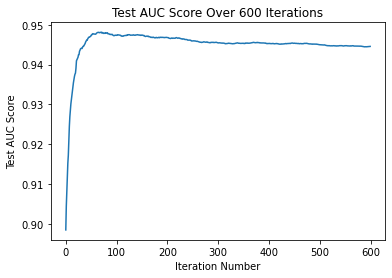

In [33]:
# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']).round(2))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

#### Compare Cross Validation ???

In [34]:
kfold = KFold(n_splits=10, random_state=7)

lr_results = cross_val_score(lr_model, X, y, cv=kfold)
xgb_results = cross_val_score(xgb_model, X, y, cv=kfold)

print("LR Accuracy: %.2f%% (%.2f%%)" % (lr_results.mean()*100, lr_results.std()*100))
print(" XGB Accuracy: %.2f%% (%.2f%%)" % (xgb_results.mean()*100, xgb_results.std()*100))

c:\users\lapec\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\users\lapec\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy: 80.87% (3.32%)
 XGB Accuracy: 93.00% (1.16%)


### 7. Feature selection

In [35]:
# Logistic Regression Features
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(lr_model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,loan_int_rate,1.078077e-04
4,loan_percent_income,9.477768e-08
20,loan_grade_E,1.099769e-08
10,loan_intent_DEBTCONSOLIDATION,8.194619e-09
21,loan_grade_F,3.377592e-09
11,loan_intent_EDUCATION,2.723888e-09
5,cb_person_cred_hist_length,2.652042e-09
13,loan_intent_MEDICAL,1.718880e-09
14,loan_intent_PERSONAL,1.285137e-09
22,loan_grade_G,9.017799e-10


In [36]:
# Print the column importances from the model
xgb_model.get_booster().get_score(importance_type = 'weight')

{'loan_percent_income': 280,
 'loan_int_rate': 497,
 'person_income': 798,
 'loan_intent_HOMEIMPROVEMENT': 40,
 'loan_grade_D': 47,
 'person_home_ownership_RENT': 57,
 'loan_intent_DEBTCONSOLIDATION': 60,
 'person_emp_length': 249,
 'loan_intent_MEDICAL': 68,
 'person_home_ownership_OWN': 48,
 'loan_grade_C': 46,
 'person_home_ownership_OTHER': 1,
 'person_home_ownership_MORTGAGE': 45,
 'cb_person_cred_hist_length': 153,
 'person_age': 245,
 'loan_intent_VENTURE': 22,
 'loan_grade_E': 24,
 'loan_grade_F': 15,
 'loan_amnt': 307,
 'loan_grade_G': 10,
 'cb_person_default_on_file_N': 25,
 'loan_intent_PERSONAL': 24,
 'loan_grade_B': 27,
 'loan_intent_EDUCATION': 29,
 'loan_grade_A': 2}

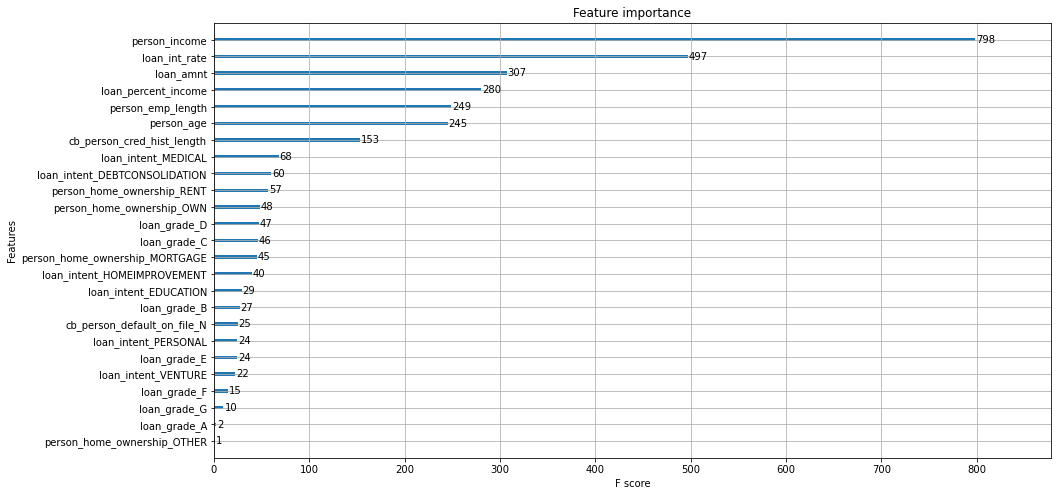

In [37]:
# Plot the column importance for this model
f, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(xgb_model, importance_type = 'weight', ax=ax)
plt.show()

### 9. Class imbalance

In [38]:
y_train.value_counts()

0    13823
1     3854
Name: loan_status, dtype: int64

Undersamping

In [39]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [40]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

1    3854
0    3854
Name: loan_status, dtype: int64


#### Stratified K-fold

In [41]:
kfold = StratifiedKFold(n_splits=10, random_state=7)

lr_results = cross_val_score(lr_model, X, y, cv=kfold)
xgb_results = cross_val_score(xgb_model, X, y, cv=kfold)

print("LR Accuracy: %.2f%% (%.2f%%)" % (lr_results.mean()*100, lr_results.std()*100))
print(" XGB Accuracy: %.2f%% (%.2f%%)" % (xgb_results.mean()*100, xgb_results.std()*100))

c:\users\lapec\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LR Accuracy: 80.20% (0.92%)
 XGB Accuracy: 90.89% (2.36%)


### Acceptance Rates

In [ ]:
# Check the statistics of the probabilities of default
print(test_pred_df['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.85)

# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(test_pred_df['pred_loan_status'].value_counts())

In [ ]:
# Plot the predicted probabilities of default
plt.hist(lr_model.predict_proba(X_test)[:,1], color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(lr_model.predict_proba(X_test)[:,1], 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

In [ ]:
# Print the top 5 rows of the new data frame
print(test_pred_df.head())

# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

### 11. Credit Strategy

In [ ]:
# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status_15']).apply(lambda x: x * avg_loan, axis = 0))

In [ ]:
# Print accept rates
print(accept_rates)

In [ ]:
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
  	# Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [ ]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

In [ ]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

In [ ]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [ ]:
# Print the contents of the strategy df
print(strat_df)

In [ ]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.axes().yaxis.grid()
plt.show()

In [ ]:
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

In [ ]:
# Print the first five rows of the data frame
print(test_pred_df.head())

# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * test_pred_df['loss_given_default']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))